In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import pandas as pd
import tensorflow as tf
from geopy.geocoders import Nominatim
import datetime
import nycsales as nyc
from scipy import stats
from sklearn.model_selection import train_test_split

#join 2015 data with the longitude and latitutde data from building shapefile
#fname = 'data/2015_brooklyn.csv'
#bk = pd.read_csv(fname,sep = ',')
#shapecsvname = 'data/BuildingFootprints_augmented.csv'
#bknew = nyc.join_latlong(bk,shapecsvname)

#a previously saved version is here, to keep large files out of the git repo
bknew = pd.read_csv('data/bk15_augmented.csv',sep = ',')


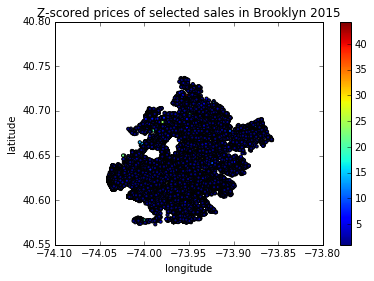

In [14]:
#grab subsslected records and visualize. This will eventually be a geotiff
#and shown in a GIS viewer. currently, Can export info as a csv file and import int QGIS
#bktemp = bknew.loc[np.random.randint(1,len(bktemp),10000),:]

#or grab all records
bktemp = bknew 

pts = 10
prices = np.array(bktemp['SALE PRICE'].tolist())
zscores = stats.zscore(prices) + abs(min(stats.zscore(prices))) + 1
bktemp.plot.scatter('long','lat',c=zscores,cmap='jet',sharex=False,s = pts)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Z-scored prices of selected sales in Brooklyn 2015')
plt.show()

In [15]:
#export prices and lat, long
bktemp.to_csv('prices_latlong_bk15.csv',columns = ['SALE PRICE','lat','long'])

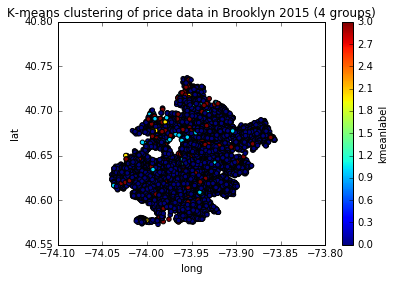

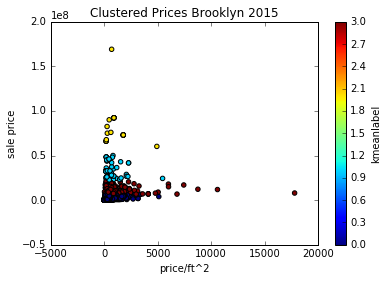

In [16]:
#try a clustering algorithm to group by prices and location
from sklearn.cluster import KMeans
#histogram of plot price per sq. ft
test1 = bknew['SALE PRICE'] > 0.0 
test2 = bknew['GROSS SQUARE FEET'] > 0.0
test3 = ~np.isnan(bknew['SALE PRICE'])
test4 = ~np.isnan(bknew['GROSS SQUARE FEET'])
test = test1 & test2 & test3 & test4

paramlist = ['SALE PRICE','GROSS SQUARE FEET','lat','long']
pd_clean = bknew.loc[test,paramlist]
#calculate price per sq. foot and add to data frame
ppsf = pd_clean['SALE PRICE']/pd_clean['GROSS SQUARE FEET']
pd_clean['ppsf']= ppsf

#k means clustering
params_eval = ['SALE PRICE','GROSS SQUARE FEET','lat','long','ppsf']
pd_eval = pd_clean.loc[:,params_eval]
kmeans = KMeans(n_clusters=4, random_state=0).fit(np.array(pd_eval))
pd_eval['kmeanlabel'] = kmeans.labels_
pd_clean['kmeanlabel'] = kmeans.labels_

pts = 20
pd_eval.plot.scatter('long','lat',c='kmeanlabel',cmap='jet',sharex=False,s = pts)
plt.xlabel('long')
plt.ylabel('lat')
plt.title('K-means clustering of price data in Brooklyn 2015 (4 groups)')
plt.show()

pd_clean.plot.scatter('ppsf','SALE PRICE',c='kmeanlabel',cmap='jet',sharex=False, s = pts)
plt.xlabel('price/ft^2')
plt.ylabel('sale price')
plt.title('Clustered Prices Brooklyn 2015')
plt.show()

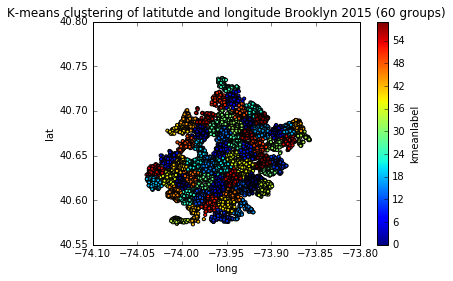

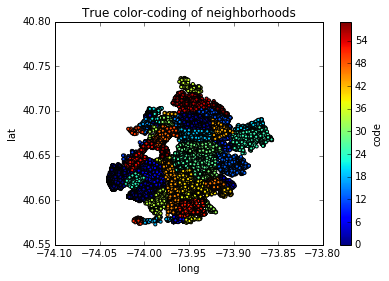

In [17]:
#what if ML made neighborhoods... 
#a clustering approach to partition neighborhoods based on clustering

neighborhoods = bknew.NEIGHBORHOOD.unique()
nn = len(neighborhoods)
#add a code for categorical neighborhoods
bknew['code'] = pd.Categorical(bknew.NEIGHBORHOOD).codes

#k means clustering of lat and long, to make "neighborhoods"
params_eval = ['lat','long']
pd_eval = pd_clean.loc[:,params_eval]
kmeans = KMeans(n_clusters=nn, random_state=0).fit(np.array(pd_eval))
pd_eval['kmeanlabel'] = kmeans.labels_
pd_clean['kmeanlabel'] = kmeans.labels_

pts = 10
pd_eval.plot.scatter('long','lat',c='kmeanlabel',cmap='jet',sharex=False,s = pts)
plt.xlabel('long')
plt.ylabel('lat')
plt.title('K-means clustering of latitutde and longitude Brooklyn 2015 (60 groups)')
plt.show()

#now plot the scatterplot of neighborhoods

bknew.plot.scatter('long','lat',c='code',cmap='jet',sharex=False,s = pts)
plt.xlabel('long')
plt.ylabel('lat')
plt.title('True color-coding of neighborhoods')
plt.show()